In [1]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

EXP_NAME = "logs/clients"
RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['time', 'start_transfer', 'download','status','download_size']

#Read input files from the directory and returns DataTable object in a combined list
def read_clients():
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]    
    proxy_data = pd.read_csv(os.path.join('clients.csv'),sep=',')
    #Load results from each node
    nodes_results = None
    for sub_dir in dirs:
        client_nodes = [f for f in os.listdir(INPUT_DIR+'/'+sub_dir) if os.path.isdir(os.path.join(INPUT_DIR+'/'+sub_dir, f))]
        #print(client_nodes)
        for node in client_nodes:
            tunnel_nodes = os.listdir(INPUT_DIR+'/'+sub_dir+'/'+node)
            for tunnel in tunnel_nodes:                
                file = os.path.join(INPUT_DIR+'/'+sub_dir+'/'+node,tunnel)             
                
                
                temp_filter = proxy_data.loc[(proxy_data['proxy'] == int(tunnel)) & (proxy_data['client'] == int(sub_dir))]
                try:
                    temp = pd.read_csv(file,sep=',', header = None)
                    temp.columns = headers
                    temp = temp.query('status == 200 & download_size >0')
                    #temp = temp.set_index(pd.DatetimeIndex(temp.time))
                    temp['proxy'] = tunnel
                    temp['client'] = sub_dir
                    temp['distance'] = temp_filter.distance.iloc[0]
                    temp['hops'] = temp_filter.hops.iloc[0]
                    temp['download_time'] = temp['download'] - temp['start_transfer']
                                                           
                    nodes_results = pd.concat([nodes_results, temp])
                except Exception as e:
                    print(node, 'EXception', e)
    return nodes_results

client_data = read_clients()

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

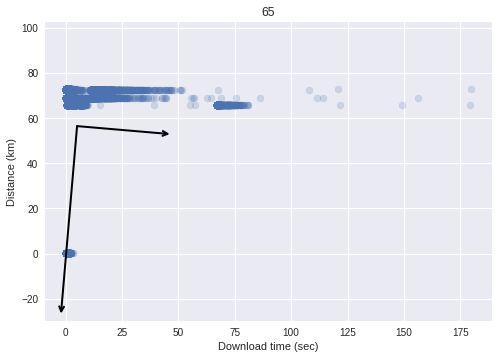

[ 773.07170811  188.68895259]
[[-0.08541127 -0.99634578]
 [ 0.99634578 -0.08541127]]


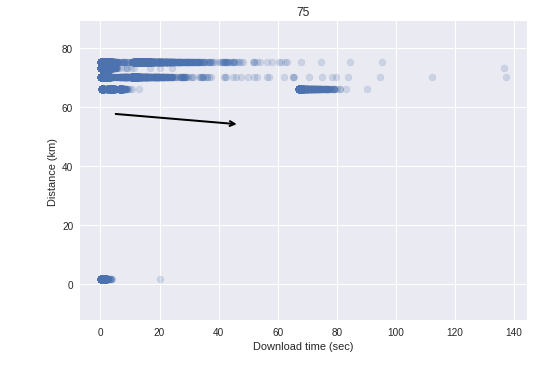

[ 766.89352675  188.04750243]
[[-0.08380103 -0.99648251]
 [ 0.99648251 -0.08380103]]


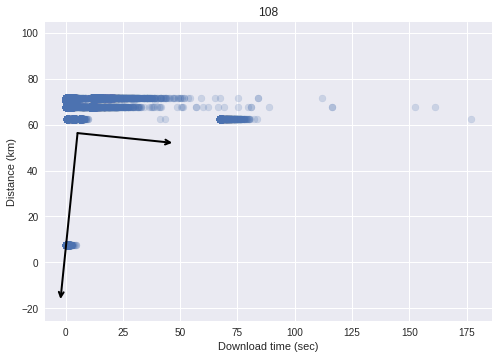

[ 588.87279843  191.64407758]
[[-0.10196313 -0.99478818]
 [ 0.99478818 -0.10196313]]


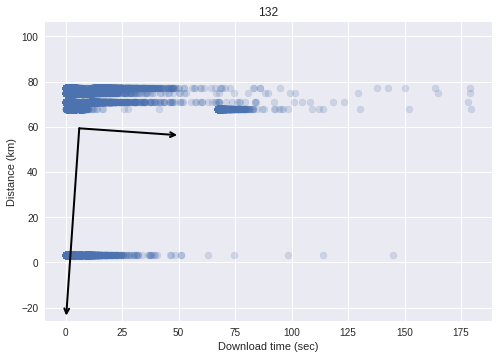

[ 767.03957542  209.51344068]
[[-0.06941412 -0.99758793]
 [ 0.99758793 -0.06941412]]


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
def plot_pca(df_clients ):
    clients = df_clients.client.unique()
    for client in clients:
        df = df_clients.query('client == "'+client+'"')
        features = ['download_time', 'distance']
        x = df.loc[:, features]        
        pca = PCA(n_components=2)
        pca.fit(x)

        plt.scatter(x.download_time, x.distance, alpha=0.2)
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 3 * np.sqrt(length)
            draw_vector(pca.mean_, pca.mean_ + v)
        plt.axis('equal')
        plt.title(client)
        plt.xlabel('Download time (sec)')
        plt.ylabel('Distance (km)')
        plt.show()
        print(pca.explained_variance_)
        print(pca.components_)
       
    

plot_pca(client_data)
   

/home/khulan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


[ 0.125     0.561795  0.561998 ...,  7.879417  8.968057  2.434777]
[ 0.125     0.561795  0.561998 ...,  7.879417  8.968057  2.434777]


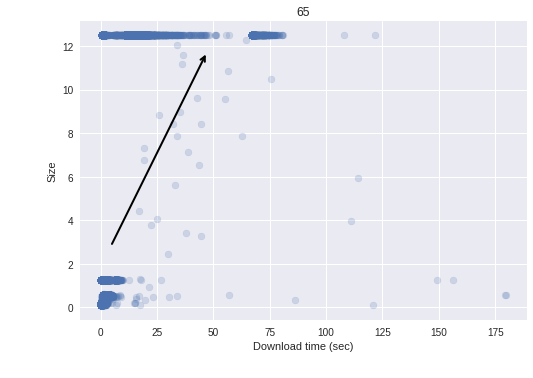

[  0.125      0.487304   0.456535 ...,   6.813817  12.066937   0.225017]
[  0.125      0.487304   0.456535 ...,   6.813817  12.066937   0.225017]


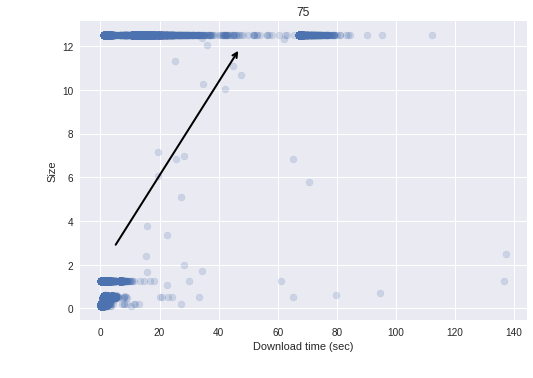

[ 0.125     0.452104  0.487185 ...,  0.613177  0.581497  1.216138]
[ 0.125     0.452104  0.487185 ...,  0.613177  0.581497  1.216138]


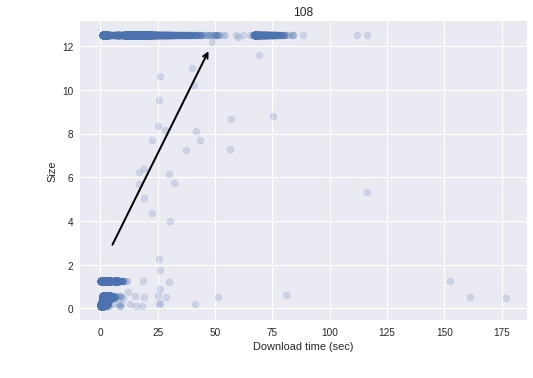

[ 0.125     0.571531  0.510805 ...,  9.514634  2.100874  1.835786]
[ 0.125     0.571531  0.510805 ...,  9.514634  2.100874  1.835786]


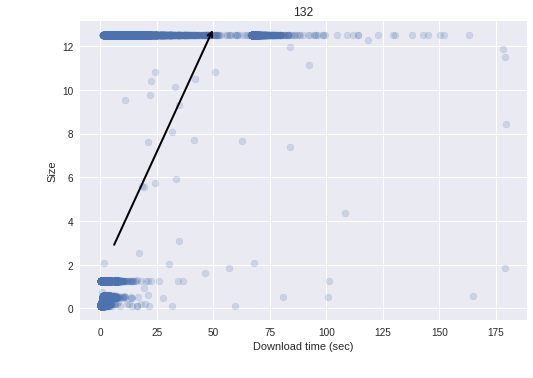

In [8]:
def plot_pca_size(df_clients):
    clients = df_clients.client.unique()
    #clients['size'] = clients['size']/1000000
    for client in clients:
                
        df = df_clients.query('client == "'+client+'"')
        df.download_size = df.download_size/1000000
        
        print(df['download_size'].unique())
        features = ['download_time', 'download_size']
        x = df.loc[:, features]
        
        print(x['download_size'].unique())
        pca = PCA(n_components=2)
        pca.fit(x)

        plt.scatter(x.download_time, x['download_size'], alpha=0.2)
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 3 * np.sqrt(length)
            draw_vector(pca.mean_, pca.mean_ + v)
        #lt.axis('equal')
        plt.title(client)
        plt.xlabel('Download time (sec)')
        plt.ylabel('Size')
        plt.show()
       
    

plot_pca_size(client_data)
   

[125000  90972  40622  89400  88089  89233  88108  89146  87693  90611]


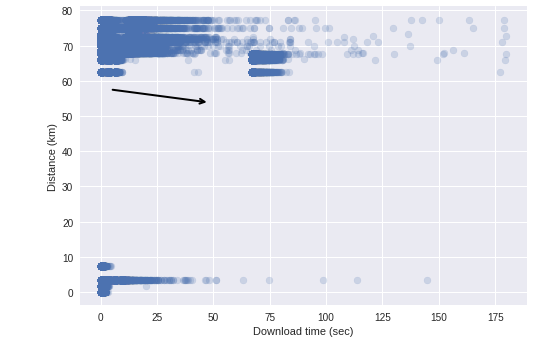

In [26]:
def plot_pca_proxy_distance(df ):
    #proxies = df_clients.proxy.unique()
    #for proxy in proxies:
        #df = df_clients.query('proxy == "'+proxy+'"')
    features = ['download_time', 'distance']
    x = df.loc[:, features]        
    pca = PCA(n_components=2)
    pca.fit(x)
    
    

    plt.scatter(x.download_time, x.distance, alpha=0.2)
    
    print((df.query('download_size<130000').download_size.unique()))
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v)
    #plt.title(proxy)
    plt.xlabel('Download time (sec)')
    plt.ylabel('Distance (km)')
    plt.show()
        
def plot_pca_proxy_size(df_clients):
    proxies = df_clients.proxy.unique()
    
    cmap = {'11252': 'red', '5126': 'blue', '57064': 'yellow', '10473':'green', '7193':'gray'}
    labels = []
    for proxy in proxies:
        df = df_clients.query('proxy == "'+proxy+'"')
        df.download_size = df.download_size/1000000
        df.download_time = df.download_time/60

        features = ['download_time', 'download_size']
        x = df.loc[:, features]
        #print((df.download_size.unique()))
        pca = PCA(n_components=2)
        pca.fit(x)
        plt.scatter(x.download_time, x.download_size, alpha=0.2, color= cmap[proxy])
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 3 * np.sqrt(length)
            draw_vector(pca.mean_, pca.mean_ + v)
        print(pca.explained_variance_ratio_)
        labels.append(proxy)
    plt.title('Overall')
    plt.legend(labels)
    plt.xlabel('Download time (sec)')
    plt.ylabel('Size (mb)')
    plt.ylim(0,2.5)
    plt.show()

plot_pca_proxy_distance(client_data)

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


65 : 5126 : 299597.819887
65 : 10473 : 1167567.07883
65 : 11252 : 2631961.27437
65 : 7193 : 27958889.2492
65 : 57064 : 29377203.2902


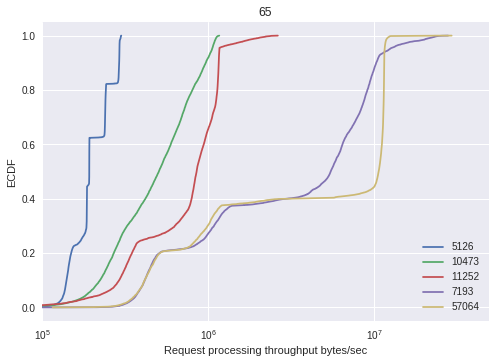

75 : 5126 : 304136.253041
75 : 10473 : 1164849.50144
75 : 11252 : 2670940.17094
75 : 7193 : 11190689.3465
75 : 57064 : 11013215.859


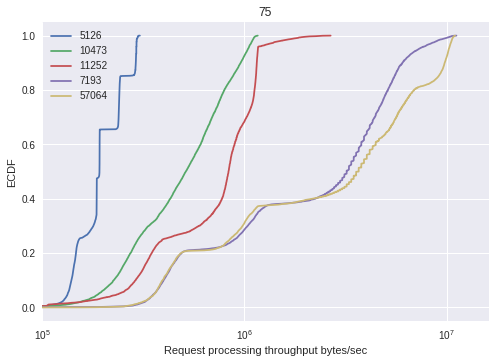

108 : 5126 : 298235.400781
108 : 10473 : 1162118.83083
108 : 11252 : 2715083.48339
108 : 7193 : 12204719.0278
108 : 57064 : 11495838.5065


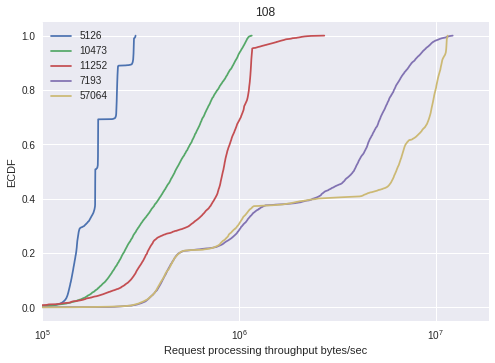

132 : 5126 : 320512.820513
132 : 10473 : 1107959.58163
132 : 11252 : 2566735.11294
132 : 7193 : 9218289.08555
132 : 57064 : 9630200.30817


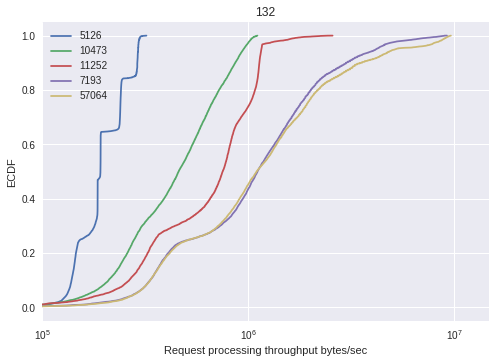

In [19]:
def getECDF(df, var):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[var].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()
    return ecdf

def plot_bytes_per_second(df_clients,var):    
    clients = df_clients.client.unique()
    for client in clients:                
        df = df_clients.query('client == "'+client+'"')
        proxies = df.proxy.unique()
        #print((df['download_size']/df['download_time']))
        df['bytes_second'] = (df['download_size']/df['download_time'])
        labels = []
        for proxy in proxies:
            df_proxy = df.query('proxy == "'+proxy+'"')            
            labels.append(proxy)
            ecdf = getECDF(df_proxy, 'bytes_second')
            ecdf.plot(logx=True)
            print(client,":",proxy,":",df_proxy.bytes_second.max())
        plt.legend(labels)
        plt.title(client)
        plt.ylabel('ECDF')
        plt.xlabel('Request processing throughput bytes/sec')
        plt.xlim(100000)
        plt.show()

plot_bytes_per_second(client_data,'download_size')

### Task 2: Plotting the latency of the nodes when downloading same content over and over every 5 minutes. Previously it was downloading diff contents.

In [2]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

EXP_NAME = "logs/client_var"
RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['time', 'start_transfer', 'download','status','download_size']
proxies = {'10.138.25.67':'5126', '10.139.40.85':'57064', '10.138.77.2':'11252',
           '10.138.57.2':'7193','10.138.85.130':'10473'}

#Read input files from the directory and returns DataTable object in a combined list
def read_clients_log():
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]  
    print(dirs)
    proxy_data = pd.read_csv(os.path.join('clients.csv'),sep=',')
    #Load results from each node
    nodes_results = None
    for sub_dir in dirs:        
        tunnel_nodes = os.listdir(INPUT_DIR+'/'+sub_dir)
        for tunnel in tunnel_nodes:                
            file = os.path.join(INPUT_DIR+'/'+sub_dir,tunnel)
            tunnel = tunnel[0:tunnel.find(':')]
            try:
                temp = pd.read_csv(file,sep=',', header = None)
                temp.columns = headers
                temp = temp.query('status == 200 & download_size >0 & download <30')
                temp = temp.set_index(pd.DatetimeIndex(temp.time))
                temp['proxy'] = proxies[tunnel]
                temp['client'] = sub_dir
                temp['download_time'] = temp['download'] - temp['start_transfer']
                nodes_results = pd.concat([nodes_results, temp])
            except Exception as e:
                print(node, 'EXception', e)
    return nodes_results

def getECDF(df, var):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[var].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()
    return ecdf

client_data = read_clients_log()
client_data.head()

['65', '75', '108', '132']


,time,start_transfer,download,status,download_size,proxy,client,download_time
time,,,,,,,,
2018-02-03 12:11:00,2018/02/03 12:11,0.007403,5.428054,200,1048576,5126,65,5.420651
2018-02-03 12:19:00,2018/02/03 12:19,0.007291,5.427816,200,1048576,5126,65,5.420525
2018-02-03 12:20:00,2018/02/03 12:20,0.006953,5.423696,200,1048576,5126,65,5.416743
2018-02-03 12:21:00,2018/02/03 12:21,0.007284,5.419459,200,1048576,5126,65,5.412175
2018-02-03 12:21:00,2018/02/03 12:21,0.007341,5.422289,200,1048576,5126,65,5.414948


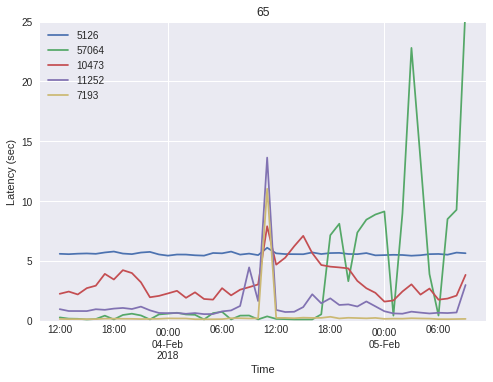

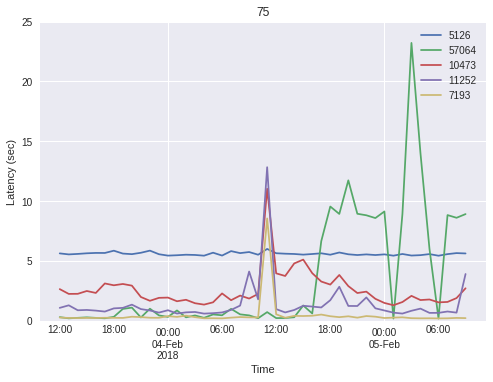

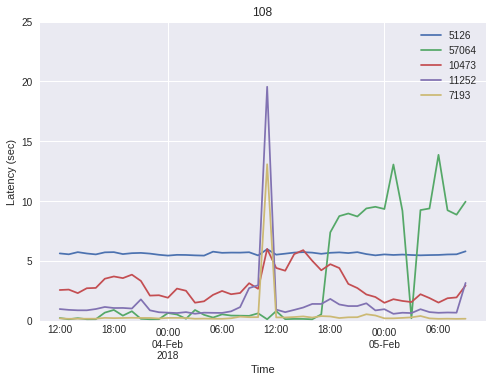

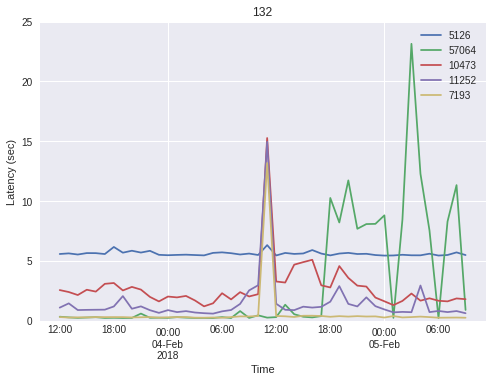

5126 > 65 > 5.5975816466618795
57064 > 65 > 2.2076945188413224
10473 > 65 > 2.723406575261158
11252 > 65 > 1.2310149271130084
7193 > 65 > 0.38523930213776697
5126 > 75 > 5.5975816466618795
57064 > 75 > 2.2076945188413224
10473 > 75 > 2.723406575261158
11252 > 75 > 1.2310149271130084
7193 > 75 > 0.38523930213776697
5126 > 108 > 5.5975816466618795
57064 > 108 > 2.2076945188413224
10473 > 108 > 2.723406575261158
11252 > 108 > 1.2310149271130084
7193 > 108 > 0.38523930213776697
5126 > 132 > 5.5975816466618795
57064 > 132 > 2.2076945188413224
10473 > 132 > 2.723406575261158
11252 > 132 > 1.2310149271130084
7193 > 132 > 0.38523930213776697


In [29]:
def plot_latency(df_clients,var):    
    clients = df_clients.client.unique()
    for client in clients:                
        df = df_clients.query('client == "'+client+'"')
        proxies = df.proxy.unique()
        labels = []
        for proxy in proxies:
            df_proxy = df.query('proxy == "'+proxy+'"')
            df_proxy = df_proxy.resample('60Min').mean()
            labels.append(proxy)
            df_proxy['download'].plot()
            #print(client,">",proxy,">",df_proxy['download'].mean())
            #ecdf = getECDF(df_proxy, 'bytes_second')
            #ecdf.plot(logx=True)
            #print(client,":",proxy,":",df_proxy.bytes_second.max())
        plt.legend(labels)
        plt.title(client)
        plt.ylabel('Latency (sec)')
        plt.xlabel('Time')
        plt.ylim(0,25)
        plt.show()

def show_avg_latency(df):
    clients = df.client.unique()
    for client in  clients:
        df_client = df.query('client == "'+client+'"')
        proxies = df_client.proxy.unique()
        for proxy in proxies:
            df_proxy = df.query('proxy == "'+proxy+'"')
            print(proxy,">", client, ">",df_proxy['download'].mean())

plot_latency(client_data,'download')
show_avg_latency(client_data)

### Plotting worst and best proxy at a time for each client

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'time' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 'time' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()


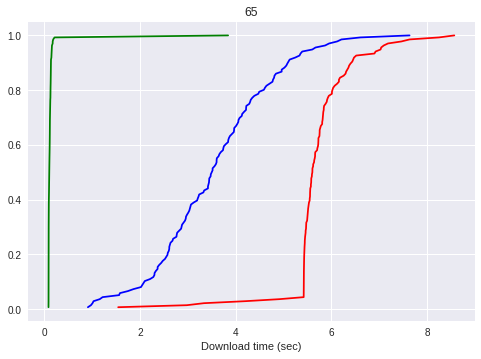

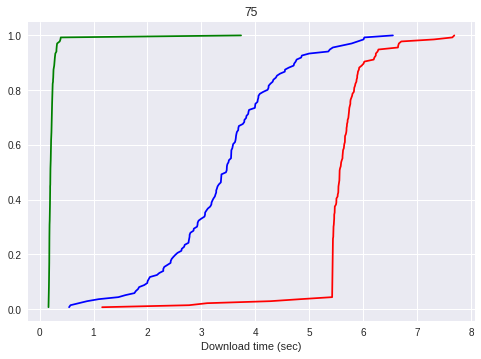

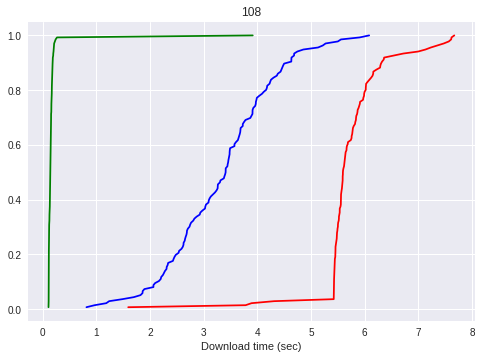

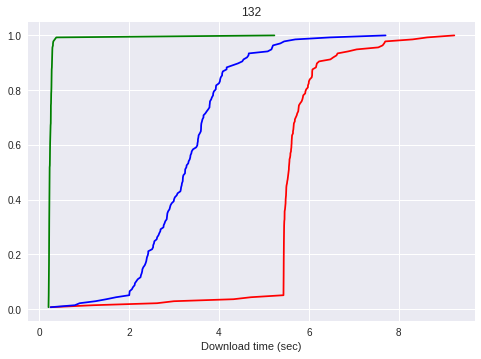

In [5]:
import random

def plot_perf(df):
    clients = df.client.unique()
    for client in  clients:
        df_client = df.query('client == "'+client+'"')
        time_seq = df_client.time.unique()
        idx = df_client.groupby(['time'])['download'].transform(max) == df_client['download']
        worst_df = df_client[idx]
        
        idx = df_client.groupby(['time'])['download'].transform(min) == df_client['download']
        best_df = df_client[idx]
        rand_df = pd.DataFrame()
        for time_st in time_seq:
            df_time = df_client.query("time == '"+time_st+"'")
            proxies = df_time.proxy.unique()
            if len(proxies) > 2:
                rand_choice = random.sample(set(proxies), 2)
                client1 = df_time.query('proxy == "'+rand_choice[0]+'"')
                client2 = df_time.query('proxy == "'+rand_choice[1]+'"')
                if float(client1.download.iloc[0]) > float(client2.download.iloc[0]):
                    rand_df = rand_df.append(client1)
                else:
                    rand_df = rand_df.append(client2)
            else:
                rand_df = rand_df.append(df_time)
        
        getECDF(worst_df.resample('20Min').mean(),'download').plot(color='red')
        getECDF(rand_df.resample('20Min').mean(),'download').plot(color='blue')        
        getECDF(best_df.resample('20Min').mean(),'download').plot(color='green')  
        plt.xlabel("Download time (sec)")
        plt.title(client)
        plt.show()
        
plot_perf(client_data)

### Task 3: Plotting client to client delay

In [6]:

EXP_NAME = "logs/c_c"
RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['min','avg','max','mdev']

#Read input files from the directory and returns DataTable object in a combined list
def read_client_client_log():
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]  
    print(dirs)
    #Load results from each node
    nodes_results = None
    for sub_dir in dirs:        
        tunnel_nodes = os.listdir(INPUT_DIR+'/'+sub_dir)
        for tunnel in tunnel_nodes:                
            file = os.path.join(INPUT_DIR+'/'+sub_dir,tunnel)
            tunnel = tunnel[0:tunnel.find('_')]
            try:
                temp = pd.read_csv(file,sep='/', header = None)
                temp.columns = headers
                temp['from'] = str(sub_dir)
                temp['to'] = tunnel
                nodes_results = pd.concat([nodes_results, temp])
            except Exception as e:
                print(node, 'EXception', e)
    return nodes_results

rtt_clients = read_client_client_log()
rtt_clients.head()

['65', '75', '108', '132']


,min,avg,max,mdev,from,to
0,3.363,4.523,6.243,1.242,65,10.228.205.132
1,5.173,5.327,5.582,0.181,65,10.228.205.132
2,2.930,3.121,3.306,0.160,65,10.228.205.132
3,3.443,4.273,4.982,0.636,65,10.228.205.132
4,2.882,3.523,4.118,0.510,65,10.228.205.132


In [17]:
def plot_rtt(df_clients,var):
    clients = df_clients['from'].unique()
    for client in clients:                
        df = df_clients.query('from =="'+ client+'"')
        proxies = df.to.unique()
        labels = []
        for proxy in proxies:
            df_proxy = df.query('to == "'+proxy+'"')
            #df_proxy = df_proxy.resample('60Min').mean()
            labels.append(proxy)
            df_proxy[var].plot()
            #ecdf = getECDF(df_proxy, 'bytes_second')
            #ecdf.plot(logx=True)
            #print(client,":",proxy,":",df_proxy.bytes_second.max())
        plt.legend(labels)
        plt.title(client)
        plt.xlabel('RTT (sec)')
        #plt.xlabel('Time')
        #plt.ylim(0,25)
        plt.show()
        
plot_rtt(rtt_clients,'download')

SyntaxError: invalid syntax (<unknown>, line 1)

### Client avg latency by size

In [22]:
EXP_NAME = "logs/clients"
RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['time', 'start_transfer', 'download','status','download_size']

def read_clients():
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]    
    proxy_data = pd.read_csv(os.path.join('clients.csv'),sep=',')
    #Load results from each node
    nodes_results = None
    for sub_dir in dirs:
        client_nodes = [f for f in os.listdir(INPUT_DIR+'/'+sub_dir) if os.path.isdir(os.path.join(INPUT_DIR+'/'+sub_dir, f))]
        for node in client_nodes:
            tunnel_nodes = os.listdir(INPUT_DIR+'/'+sub_dir+'/'+node)
            for tunnel in tunnel_nodes:                
                file = os.path.join(INPUT_DIR+'/'+sub_dir+'/'+node,tunnel)             
                
                
                temp_filter = proxy_data.loc[(proxy_data['proxy'] == int(tunnel)) & (proxy_data['client'] == int(sub_dir))]
                try:
                    temp = pd.read_csv(file,sep=',', header = None)
                    temp.columns = headers
                    temp = temp.query('status == 200 & download_size >0')
                    #temp = temp.set_index(pd.DatetimeIndex(temp.time))
                    temp['proxy'] = tunnel
                    temp['client'] = sub_dir
                    temp['distance'] = temp_filter.distance.iloc[0]
                    temp['hops'] = temp_filter.hops.iloc[0]
                    temp['download_time'] = temp['download'] - temp['start_transfer']
                    temp['size_range'] = node         
                    nodes_results = pd.concat([nodes_results, temp])
                except Exception as e:
                    print(node, 'EXception', e)
    return nodes_results

client_data = read_clients()

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

In [26]:
def show_avg_latency(df):
    proxies = df.proxy.unique()
    for proxy in proxies:
        df_proxy = df.query('proxy == "'+proxy+'"')
        size_range = df_proxy.size_range.unique()
        #print(size_range)
        for rng in size_range:
            df_rng = df_proxy.query('size_range =="'+rng+'"')
            print(proxy,">",rng,'>',df_rng['download'].mean())
            
show_avg_latency(client_data)

5126 > 1mb > 0.5798892787760198
5126 > youtube > 3.9202988827610725
5126 > 10mb > 6.696906938456036
5126 > bbc > 1.3521059061776732
5126 > 100mb > 68.52015456705799
10473 > 1mb > 0.4324832896223089
10473 > youtube > 2.733728521792842
10473 > 10mb > 2.0959267819336644
10473 > bbc > 1.232922438426256
10473 > 100mb > 19.438105258514234
11252 > 1mb > 0.717037980846951
11252 > youtube > 2.547542324510322
11252 > 10mb > 1.7959885427868656
11252 > bbc > 1.142229919019054
11252 > 100mb > 14.731744593468663
7193 > 1mb > 0.15154635342706513
7193 > youtube > 1.5635266061511428
7193 > 10mb > 0.5716703848181327
7193 > bbc > 0.6941541487341796
7193 > 100mb > 3.8662937906854196
57064 > 1mb > 0.6823351689003115
57064 > youtube > 1.5420918369585406
57064 > 10mb > 0.5691639364701581
57064 > bbc > 0.6976431736263722
57064 > 100mb > 3.1788008863262007
